# Genome-scale metabolic modeling

Metabolic reactions underpin cellular function, converting nutrients into energy and cellular building blocks. Genome-scale metabolic models (GEMs) offer a holistic representation of these pathways based on an organism's genome, providing insights into its metabolic potential under various conditions. GEMs represent the collection of metabolic reactions as a [biochemical network](https://en.wikipedia.org/wiki/Metabolic_network), in which nodes represent metabolites (chemical compounds) and edges are reactions in which these metabolites participate either as substrates or as products. Additionally, GEMs include the _stoichiometry_ with which a metabolite participates in each reaction (that is, the number of molecules of each metabolite involved in the reaction).By convention, positive stoichiometric coefficients represent products and negative stoichiometric coefficients represent substrates.

> As a curiosity, biochemical networks cannot be represented by simple graphs, but rather by [hypergraphs](https://en.wikipedia.org/wiki/Hypergraph), in which edges connect more than two nodes. This is because biochemical reactions may involve multiple substrates and products. 

As in with any graph, we can represent a biochemical network by its [incidence matrix](https://en.wikipedia.org/wiki/Incidence_matrix), the stoichiometric matrix, $S$, which is a central piece of a GEM. In $S$, columns represent reactions and rows metabolites. Thus, its entries $s_{ij}$ represent the stoichiometric coefficient of metabolite $i$ in reaction $j$. Most metabolites participate in a small number of reactions, so $S$ is a sparse matrix, where most of its entries are 0.

### A toy network example

Here is a toy biochemical network with 6 metabolites $A-F$ and 5 reactions $R_{1-5}$ to help us visualize how the stoichiometric matrix is constructed. Note that in this case all stoichiometric coefficients are 1, but in actual GEMs they can be any integer (or even a fraction in the case of the biomass pseudo-reaction). Note that column vectors represent reactions, while row vectors, metabolites:

<div style="width:100%; text-align:center;">
<img src="images/toy_network.png" alt="toy network" style="width: 20%; height: auto; margin: auto">
</div>

The stoichiometric matrix $S$ is constructed by stacking the column vectors of the network, so that the first column of $S$ is the vector representing reaction $R_1$, while the first row of $S$ is the vector representing metabolite $A$, and so on. Thus, the first entry of $S$ is the stoichiometric coefficient of metabolite $A$ in reaction $R_1$ (acting as a substrate in this case):

$$
S = 
\begin{align*}
\begin{pmatrix}
-1 & 0 & 0 & -1 & 0 \\
1 & -1 & 0 & 0 & 0 \\
1 & 1 & -1 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & -1 \\
0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
\end{align*}
$$

Now, reactions transform substrates into products at a given rate, or flux. This flux is typically measured in $mmol$ of transformed product per unit time per dry weight. The interesting thing about $S$ is that it allows us to model reaction fluxes, let's name the vector of fluxes $v$. The flux vector $v$ is a vector of real numbers, where each entry $v_j$ represents the flux of reaction $j$, and it is related to the stoichiometric matrix $S$ by the following equation:

$$\frac{d}{dt}x = Sv,$$

and under [steady-state]() conditions, where the concentration of each metabolite is constant, we have:

$$Sv = 0.$$

The above is typically an underdetermined system of linear equations. Thus, instead of a single solution, we end up with a space of possible solutions, $v$, which is called the _nullspace_ of $S$. However, reaction fluxes are subject to maximum capacity and thermodynamic constraints. Ther former restricts the maximum flux of each reaction, while the latter restricts the direction of fluxes. These constraints are typically represented by a vector of lower and upper bounds, $v_{min}$ and $v_{max}$, respectively. Thus, the space of possible solutions is further restricted to the _feasible flux space_, a.k.a. the [flux cone]() $F$, which is the set of all flux vectors satisfying:

$$F = \{v: Sv = 0, v_{min} \leq v \leq v_{max}\}.$$ 


# Genome-scale models in cobrapy

`cobrapy` (COnstraint-Based Reconstruction and Analysis in PYthon) is a Python package for constraint-based modeling of metabolic networks. It provides a set of tools for the analysis of GEMs, including the ability to read and write GEMs in the [SBML]() format, and to perform [flux balance analysis]() (FBA) and [flux variability analysis]() (FVA). In this tutorial, we will use `cobrapy` to analyze a GEM of the marine diatom [_Thalassiosira pseudonana_](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0241960).

In [1]:
import numpy as np
import cobra
import pandas as pd
import matplotlib.pyplot as plt
from escher import Builder

from phycogem.reconstruction import GEM
from phycogem.reconstruction_helpers import get_medium_dict_from_media_db, get_dict_of_metabolite_ids
from phycogem.visualization import plot_flux_distribution, rename_rxn_ids_for_escher

In [2]:
gem = GEM("../data/models/iTps1432_high.xml")
gem.rescale_fluxes(maximum_flux=1000)
gem

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-05
Read LP format model from file /tmp/tmpw291ode8.lp
Reading time = 0.03 seconds
: 2792 rows, 12158 columns, 53548 nonzeros


Name,iTps1432
Memory address,7fcfa9b6a1d0
Number of metabolites,2792
Number of reactions,6079
Number of genes,1432
Number of groups,93
Objective expression,4.0*DM_biomass_c - 4.0*DM_biomass_c_reverse_c49c1
Compartments,"plastid, mitochondria, cytosol, peroxisome, thylakoid membrane, extracellular"


In the summary above, we see that the model contains over 6000 biochemical reactions and more than 2700 metabolites, which are partitioned into 6 compartments: plastid, mitochondria, cytosol, peroxisome, thylakoid membrane and extracellular space. Note that _Thalassiosira_ is a phototrophic eukaryote (a microalga), thus it contains chloroplasts alongside mitochondria. A special reaction within the model is the _biomass_ reaction, a pseudo-reaction that represents the growth of the organism (more on this later), and which is set as the objective function of the model.

We can extract the stoichiometric matrix of the model as follows:

In [3]:
S = cobra.util.create_stoichiometric_matrix(gem.model)
print(f"The shape of S is {S.shape}")
print(f"S contains {100 * np.count_nonzero(S) / S.size}% non-zero elements")
print(" ")
print(S)

The shape of S is (2792, 6079)
S contains 0.1577486683217295% non-zero elements
 
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.04010769  0.
   0.        ]
 [ 0.          0.          0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ... -0.01311877  0.
   1.        ]]


As expected, the number of rows of the stoichiometric matrix $S$ coincides with the number of metabolites in the model, while the number of columns is the number of reactions. Additionally, only 15.8% of its entries (stoichiometric coefficients) are non-zero, which is a consequence of the sparsity of the matrix.

## Reactions and metabolites

Genome-scale models are composed of a collection of reactions and metabolites. In `cobrapy`, these are represented by the `Reaction` and `Metabolite` classes, respectively. Here is an example corresponding to the reaction catalyzed by the _Glutamate synthase_:

In [4]:
glutamte_synthase = gem.model.reactions.get_by_id("GLTS_c")
glutamte_synthase

Reaction identifier,GLTS_c
Name,Glutamate synthase (ferredoxin)
Memory address,0x7fcfa8f51050
Stoichiometry,akg_c + 2.0 fdxrd_c + gln__L_c + 2.0 h_c --> 2.0 fdxox_c + 2.0 glu__L_c 2-Oxoglutarate + 2.0 Ferredoxin (reduced) [2Fe-2S] + L-Glutamine + 2.0 H+ --> 2.0 Ferredoxin (oxidized) [2Fe-2S] + 2.0 L-Glutamate
GPR,(Thaps3a_25232 and Thaps3a_23239) or (Thaps3a_42243 and Thaps3a_23239) or (Thaps3a_267266 and...
Lower bound,0.0
Upper bound,1000.0


We see that the reaction has a name, a unique identifier, a list of substrates and products, and a list of genes that catalyze it. Additionally, it has a lower and upper bound, which are the minimum and maximum fluxes allowed for the reaction, respectively. The reaction also has a `gene protein reaction` (GPR) rule, which is a Boolean expression that describes the genes that catalyze the reaction.  GPR rules play a pivotal role in constraint-based modeling, especially when predicting the effect of gene knockouts on the metabolic capabilities of an organism, as they dictate whether a reaction can proceed based on the presence (or absence) of specific genes.

In GPR rules, the association between genes and reactions is enconded by boolean operators. Associations may be of type:

* One-to-One: One gene codes for the enzyme that catalyzes a specific reaction.
* AND relationship: A reaction requires the products of multiple genes (e.g., subunits of a protein complex). All these genes must be present for the reaction to be feasible.
* OR relationship: A reaction can be catalyzed by the product of any one of several genes.

For example, in the case of the _Glutamate synthase_ we have:

In [5]:
glutamte_synthase.gene_reaction_rule

'(Thaps3a_25232 and Thaps3a_23239) or (Thaps3a_42243 and Thaps3a_23239) or (Thaps3a_267266 and Thaps3a_23239) or (Thaps3a_259373 and Thaps3a_23239)'

Hence, this reaction may be catalyzed by any of the gene products displayed above. Finally, we can take a brief look at an instance of the class `Metabolite`. In this case, a substrate of the _Glutamate synthase_ reaction, _2-oxoglutarate_:

In [6]:
oxoglutarate = gem.model.metabolites.get_by_id("akg_c")
oxoglutarate

Metabolite identifier,akg_c
Name,2-Oxoglutarate
Memory address,0x7fcfa9289b50
Formula,C5H4O5
Compartment,c
In 27 reaction(s),"GLUDH2_c, ICDH_c, MTOBTA_c, GLTS_c, SEPHCHCS_c, CYSTA_c, PSAT_c, LCYSTAT_c, AKGMALt_h, HGDH_c, PRO4H_c, AKGCITt_m, IAPTA_c, ALATA_L_c, GLUDH_c, BCTAI_c, MALAKGt_m, POAT_c, ASPTA_L_c, GLYTA_c,..."


The metabolite has a name, a unique identifier, a cellular compartment (cytosol in this case), and a formula. Additionally, it has a charge, which is the number of protons it carries. Finally, it has a list of reactions in which it participates.

## Flux balance analysis

Now that we have described what a genome-scale metabolic model contains, we are ready to run some simulations. The first one we will perform is a flux balance analysis (FBA). In FBA, we assume that the organism is in a steady-state, and that it is optimizing a given objective function. In the case of _Thalassiosira_, the objective function is the _biomass_ pseudo-reaction, which represents the growth of the organism. Thus, the FBA problem is formulated as follows:

$$\max_{v} v_{biomass}$$

$$\text{s.t. } Sv = 0$$

$$v_{min} \leq v \leq v_{max}$$

where $v$ is the flux vector, $v_{biomass}$ is the flux of the biomass reaction, $S$ is the stoichiometric matrix, and $v_{min}$ and $v_{max}$ are the lower and upper bounds of the fluxes, respectively. The solution to the above problem is the flux vector that maximizes the biomass reaction, while satisfying the steady-state and capacity constraints. 

Note that reaction fluxes are bounded by minimum and maximum fluxes. In our case, we will constrain the exchange reactions that control which metabolites can enter the cell (including here photons as well since _Thalassiosira_ is a photosynthetic orgnaism). We can do this bby defining a growth medium and passing the object to the `medium` attribute of the model:

In [7]:
medium_id = "MARINE[iTPS1432]"
energy_source = ("EX_photon650_e", 200)
met_names = get_dict_of_metabolite_ids("../data/compounds/BIGG_metabolites.json")

medium = get_medium_dict_from_media_db(
    "../data/marine_media/media_db.tsv",
    medium_id
)

for rxn_ex in medium:
    met_id = "_".join("_".join(rxn_ex.split("_")[1:]).split("_")[:-1])
    print(f"{met_id}: {met_names[met_id] if met_id in met_names else met_id}")

glyb: Glycine betaine
btn: Biotin
co: Carbon monoxide
co2: CO2 CO2
cobalt2: Co2+
cu2: Copper
fe2: Fe2+ mitochondria
fe3: Iron (Fe3+)
h2: Hydrogen
h2o: H2O H2O
hco3: Bicarbonate
k: Potassium
mg2: Magnesium
mn2: Manganese
na1: Sodium
nh4: Ammonium
no2: Nitrite
no3: Nitrate
o2: O2 O2
photon650: Photon (640nm-660nm)
pi: Phosphate
h: H+
so4: Sulfate
urea: Urea CH4N2O
zn2: Zinc
cl: Chloride
thm: Thiamin
fol: Folate
sio4h4: sio4h4


In [8]:
# Set growth medium (autotroph) and optimize growth
gem.set_medium(medium_id, "../data/marine_media/media_db.tsv", energy_source=energy_source)
sol = gem.model.optimize()
print(f"The maximum growth rate is {sol.objective_value:.2f} 1/h")

The maximum growth rate is 0.47 1/h


### How maximum nitrogen uptake rate affects growth rate

As shown above, the maximum growth rate given the constraints imposed by the medium is 0.47 $h^{-1}$. As an exercise, let's see how the maximum growth rate changes when we limit the maximum allowed influx of a source of nitrogen, in this case, urea:

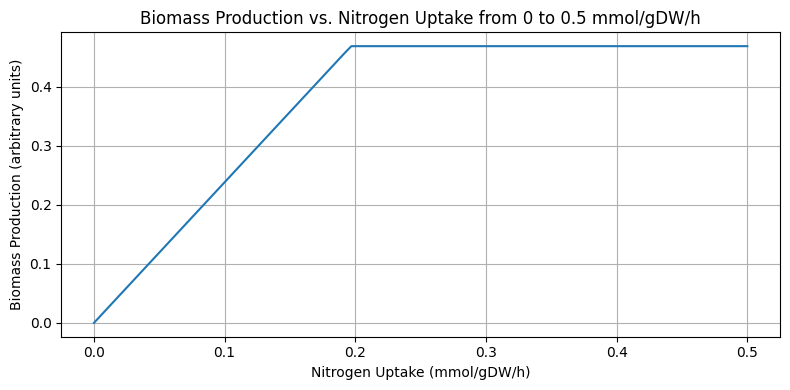

In [9]:
max_nitrogen_uptake = -0.1
gem.model.reactions.get_by_id("EX_no3_e").lower_bound = 0
gem.model.reactions.get_by_id("EX_nh4_e").lower_bound = 0
gem.model.reactions.get_by_id("EX_no2_e").lower_bound = 0
gem.model.reactions.get_by_id("EX_urea_e").lower_bound = max_nitrogen_uptake

nitrogen_fluxes = np.linspace(0, 0.5, 100)
biomass_values = []
ex_urea = gem.model.reactions.get_by_id('EX_urea_e')
for no3_influx in nitrogen_fluxes:
    ex_urea.lower_bound = -no3_influx
    solution = gem.model.optimize()
    biomass_values.append(4 * solution.fluxes['DM_biomass_c'])

ex_urea.lower_bound = max_nitrogen_uptake
plt.figure(figsize=(8, 4))
plt.plot(nitrogen_fluxes, biomass_values, color='tab:blue')
plt.xlabel('Nitrogen Uptake (mmol/gDW/h)')
plt.ylabel('Biomass Production (arbitrary units)')
plt.title('Biomass Production vs. Nitrogen Uptake from 0 to 0.5 mmol/gDW/h')
plt.grid(True)
plt.tight_layout()
plt.show()

We see that the maximum growth rate increases as we increase the maximum influx of urea. This is because a source of nitrogen is an essential nutrient to sustain growth. However, the maximum growth rate plateaus at 0.47 $h^{-1}$, which is the previously identified maximum growth rate when we were not limiting the nitrogen source. 

## Analyzing the flux cone: flux variability analysis and flux sampling

Now that we have identified the maximum growth rate of _Thalassiosira_, we can analyze the flux cone, that is, the space of feasible flux vectors. We will do this by performing a [flux variability analysis](https://opencobra.github.io/cobratoolbox/stable/tutorials/tutorialFVA.html) (FVA), which consists of finding the minimum and maximum fluxes of each reaction in the model across the feasible flux space. This is done by solving the following problems for each reaction $j$:

$$\min_{v} (\max_{v}) v_j$$

$$\text{s.t. } Sv = 0$$

$$v_{min} \leq v \leq v_{max}.$$

`cobrapy` contains its own implementation of FVA, which is called by the wrapper function `compute_flux_ranges`:

In [10]:
# Run flux variability analysis
fva = gem.compute_flux_ranges()
fva.head()

,minimum,maximum
IDP_m,0.000004,268.503125
ATAM_c,0.204501,272.661868
GLTS_c,0.000000,19.998655
GLNA_h,0.000000,429.691441
GLNA_m,0.000000,411.588133


We see that in the case of the _Glutamate synthase_ reaction, the minimum and maximum fluxes are 0.00 and 19.99 $mmol \cdot gDW^{-1} \cdot h^{-1}$, respectively. This means that the reaction can only proceed in the forward direction and that its maximum flux is largely limited by the impossed constraints (the maximum allowed bound in the model is 1000 $mmol \cdot gDW^{-1} \cdot h^{-1}$).

In addition to FVA, we can also randomly sample the feasible flux space, which is very useful to get an idea of how flux values distribute across the feasible space for each reaction. Again, `cobrapy` contains methods to sample the flux space, which can be called by the wrapper function `sample_flux_space`, although for convenience, we will load an already computed sample here:   

In [11]:
# sample = gem.sample_flux_space(n_samples=1000, n_processes=14)
# sample.to_csv("../results/flux_samples/ps_photoeuk_noSK.csv")
sample = pd.read_csv("../results/flux_samples/ps_photoeuk_noSK.csv", index_col=0)
sample.head()

,IDP_m,ATAM_c,GLTS_c,GLNA_h,GLNA_m,FACOAL_181_9Z_c,ACS_c,UTAL_h,UTAL_c,ASPTA_L_h,...,biomass_mem_lipids_c,biomass_TAG_c,biomass_pigm200_h,biomass_osmo_c,biomass_vit_c,biomass_chitin_c,biomass_frustule_c,bof200_c,biomass_EPS_c,biomass_polyp_c
0,1.103715,13.031286,0.000303,0.388059,0.054601,5.115638,0.119360,4.085367e-07,9.768254e-07,-0.000961,...,0.000003,2.871360e-07,7.327331e-07,0.000001,7.757602e-08,0.000001,0.000001,0.000036,0.000013,4.680156e-07
1,1.102270,13.031835,0.000350,0.392909,0.054662,5.115899,0.119097,4.089396e-07,1.009436e-06,-0.000668,...,0.000003,2.939786e-07,7.501945e-07,0.000001,7.942468e-08,0.000001,0.000001,0.000037,0.000006,4.791686e-07
2,1.099686,13.031577,0.000350,0.392439,0.054659,5.115833,0.119031,4.060807e-07,1.011241e-06,-0.000647,...,0.000003,2.937601e-07,7.496370e-07,0.000001,7.936566e-08,0.000001,0.000001,0.000036,0.000006,4.788125e-07
3,1.097722,13.036015,0.000217,0.296551,0.054664,5.115981,0.118251,4.060770e-07,1.011232e-06,-0.000547,...,0.000003,2.937574e-07,7.496300e-07,0.000001,7.936492e-08,0.000001,0.000001,0.000036,0.000010,4.788081e-07
4,1.100415,13.036063,0.000217,0.289427,0.054665,5.116017,0.118169,4.329187e-07,1.031640e-06,-0.000548,...,0.000003,3.035507e-07,7.746213e-07,0.000001,8.201080e-08,0.000001,0.000002,0.000038,0.000010,4.947706e-07


## Visualizing flux ranges and sampled distributions

Now that we have obtained flux ranges and a sample of the feasible flux space for our constraints, let's visualize them in a small metabolic map of the central carbon metabolism as an example. We will use [Escher](https://escher.github.io/#/) to create an interactive map and employ the flux range as flux data to represent in each reaction. If we think of reactions as water pipes, the flux range would represent their diameter.

In [12]:
# Compatibility with E. coli escher map
reaction_id_dict = {
    "ACN_a": "ACONTa",
    "ACN_b": "ACONTb",
    "SCS": "SUCOAS",
    'OGDH_E2': 'AKGDH',
    'CISY': 'CS',
    'PEPC': 'PPC',
    'PEPCK': 'PPCK',
    'PDH_E2': 'PDH',
    'GAPDH': 'GAPD',
    'TKL1': 'TKT1',
    'TKL2': 'TKT2',
    'PGDH': 'GND',
    'G6PDH': 'G6PDH2r',
    'GLK': 'GLCpts',
    "ICDH": "ICDHyr",
    "SDH": "SUCDi",
}
# fluxes = sample.mean()
fluxes = fva['maximum'] - fva['minimum']
fluxes = rename_rxn_ids_for_escher(fluxes, reaction_id_dict)

### Escher map of the central carbon metabolism

Here is an image of the rendered escher map displaying the flux ranges of the reactions in the central carbon metabolism:

![example escher map](images/example_escher_map.png)

Additionally, you can get an interactive version of this map by running the cell below!

In [13]:
# builder = Builder(
#     map_json='../data/escher_maps/iTPS1432_escher.json',
#     reaction_data=fluxes,
# )
# builder

Finally, let's represent the sampled distributions of flux values for the reactions belonging to the TCA cycle. We will see that not only flux ranged but also sampled distributions typically differ among reactions.

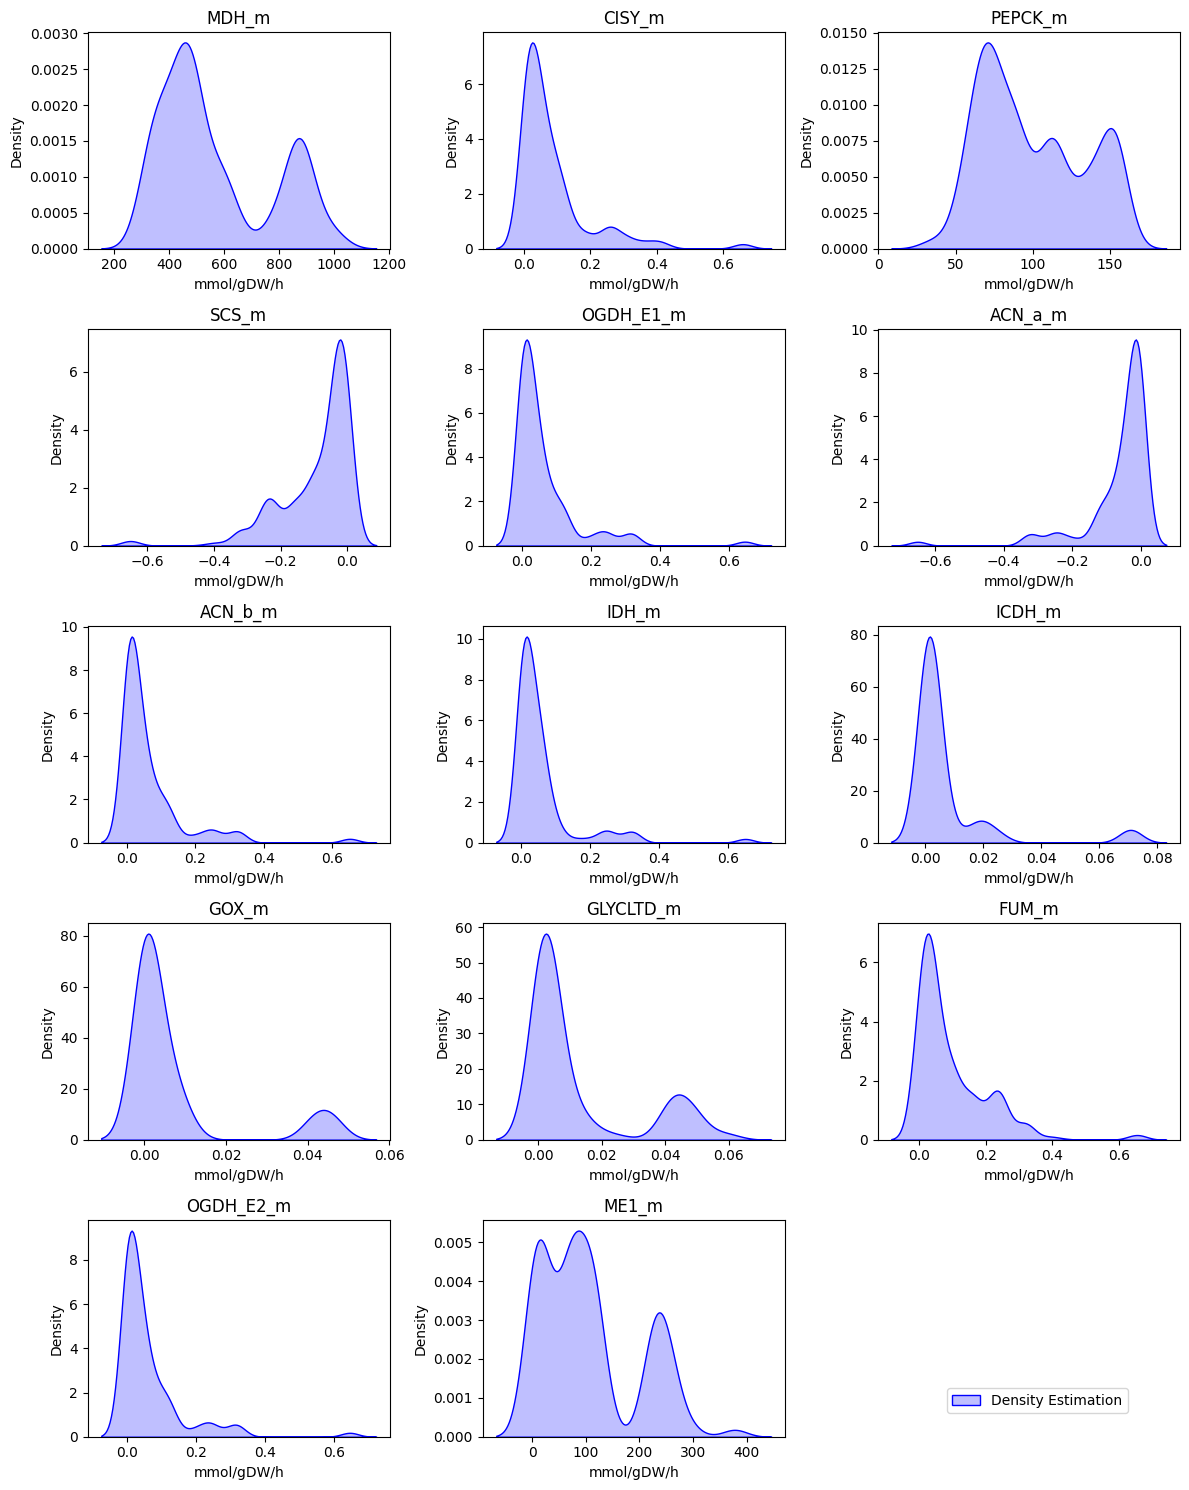

In [14]:
tca_rxns = [
    (rxn.id, rxn.subsystem)
    for rxn in gem.model.reactions
    if ("TCA cycle" in rxn.subsystem and "m" in rxn.compartments)
    ]
rxn_ids = [rxn[0] for rxn in tca_rxns]
plot_flux_distribution(sample, rxn_ids, fva=None, figsize_per_plot=(4, 3))

## Conclusions

That's it! In this brief tutorial, we have learned how to load a genome-scale metabolic model in `cobrapy`, how to perform flux balance analysis, flux variability analysis and flux sampling, and how to visualize the results in an interactive metabolic map. We have also learned how to analyze the flux cone of a model, which is a very useful tool to understand the metabolic capabilities of an organism. Now you are ready to go do some constraint-based modeling of your own!